This notebook is a condensed and summarized version of our work, all our code (for instance those used to generate plots) are not present in this notebook. For the complete notebook check the [Git repository](https://github.com/Ellana42/NLP_Ensae) 

First import required libraries

In [ ]:
#@title imports

from IPython.display import clear_output
from IPython.display import Image
!pip install transformers[sentencepiece]
clear_output()

import glob
import json
import re
import pickle
import os
import shutil
import functools
import torch
import gdown
import time
import nltk
import string
import pprint

import numpy as np
import random as rd
import pandas as pd

from math import log
from collections import defaultdict,Counter
from pathlib import Path

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn

from transformers import CamembertModel, CamembertTokenizer
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

from torchtext.vocab import FastText,vocab
from torch.utils.data import Dataset,DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.


True

For the style transfer model, we use a limited size vocabulary embedding. 

What we did was the following : we made a list of the words that appeared at least 10 times in total in either the articles or Proust's texts.

Following that, we loaded a pretrained vocabulary embedding from (torchtext.Fasttext) and retrieved the embeddings of these words.

We made the necessary string to int (stoi) and int to string (itos) lists.

Each word of the vocabulary was characterised by its index. (if we want to retrive a word's embedding, we lookup its index and return the embedding having this index)

Following that, we used this list of words as a basis for our embedding.

We chose to use a limited vocabulary size embedding as the output of our style model is a vector of the size our vocabulary len, and we did not want to make the training too heavy. 

In [ ]:
#@title load our vocabulary embedding vectors, stoi and itos
!gdown https://drive.google.com/uc?id=1RshSrc75VhX-5p0cQwDKO_lrIVR7AKbr
!gdown https://drive.google.com/uc?id=1OBb9ZDGwPuZv3crnBYFNYkpbfLHeZGZp
!gdown https://drive.google.com/uc?id=1NPqaoWQ7cdEnedc-ZIXA67czLVy0WgpO

pretrained_vectors = torch.load("/content/embedding.pt")

with open("/content/stoi.pickle","rb") as f:
  stoi = pickle.load(f)

with open("/content/itos.pickle","rb") as f:
  itos = pickle.load(f)

ft_vocab=vocab(stoi)
print("index of </s> token is",ft_vocab["</s>"])
#Now add special tokens at the end of the vocab to avoid embedding issues later on
#since inserting them in the middle of the stoi vocab will shift all other indexes, which would mess us the embedding
#when using nn.embedding later on
index_pad=len(ft_vocab)#padding
index_unk=len(ft_vocab)+1#unknown 
index_sos=len(ft_vocab)+2#start of sentence


ft_vocab.insert_token("<pad>",index_pad)
ft_vocab.insert_token("<unk>",index_unk)
ft_vocab.insert_token("<s>",index_sos)

ft_vocab.set_default_index(index_unk)


clear_output()

We Then define a simple regular expression based tokenizer that we will be using for the style transfer model.

In [ ]:
#@title define tokenizer for style transfer model
#Simple regular expression based tokenizer which tokenizes based on non alpha numeric characters, and which
#tokenizes "d'une" as "d'" and "une"
tokenizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')


def tokenize_sentence(sentence: str,tokenizer: RegexpTokenizer):
  '''Simple tokenizer, removes or replaces special characters
  sentence : str sentence to be tokenized
  tokenizer : tokenizer with tokenize method '''

  #Lower capital leters
  tokenized=sentence.lower()
  #Change special character
  tokenized=re.sub("’","'",tokenized)
  #Remove unwanted characters
  tokenized=re.sub("(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)","",tokenized)
  tokenized=re.sub("\/","",tokenized)
  #Replace articles since model does not embed contractions well
  tokenized=re.sub("l'","le ",tokenized)
  tokenized=re.sub("d'","de ",tokenized)
  tokenized=re.sub("j'","je ",tokenized)
  tokenized=re.sub("qu'","que ",tokenized)
  tokenized=re.sub("t'","te ",tokenized)
  tokenized=re.sub("c'","ce ",tokenized)
  #Tokenize sentence
  tokenized=tokenizer.tokenize(tokenized)
  return(tokenized)

tokenizer_function=functools.partial(tokenize_sentence,tokenizer=tokenizer)

Since we are using non parallel corpora for style embedding, meaning that for a sentence of a given style we do not have the equivalent sentence in the other style, we train a style conditionnal autoencoder. We use a model proposed by the paper [Style Transfer from Non-Parallel Text by Cross-Alignment](https://arxiv.org/abs/1705.09655) as basis.

The main idea behind the paper is to create a style conditional auto-encoder. This auto encoder should be so that the style latent representation should be independent from the content latent representation. To do that, they propose 2 different models, **Aligned auto encoder** and **cross aligned auto encoder** which make use of discriminators. 

Since adding discriminators makes training (and defining model) more tedious, we decided to work with a simpler model.

The structure of the style model is the following :  it is an encoder decoder based seq2seq model, where the initial hidden state of the encoder depends on the the style of
our entry texts, and where the initial hidden state
of the decoder depends on the embedding of the
content of the input texts (this embedding is taken
from the output hidden state of the encoder) and
on the target styles of our output texts 

The final hidden state of the decoder outputs is embedded using a linear layer to a vector of dimension the size of the vocabulary, and we use this vector to predict the next output token.

For the embedding, additionnaly to the smaller size vocabulary embedding defined before, we add a padding embedding defined as a zero vector, and a trainable embedding layers of size 2 ( 2 embedded words) to learn the embedding of the tokens $<s>$ (beginning of sentence) and $<unk>$ (unknown) which are not present int fasttext embedded vectors and therefore are not present in our smaller size vocabulary embedding vectors.

The structure of the style model is the following :  it is an encoder decoder based seq2seq model, where the initial hidden state of the encoder depends on the the style of
our entry texts, and where the initial hidden state
of the decoder depends on the embedding of the
content of the input texts (this embedding is taken
from the output hidden state of the encoder) and
on the target styles of our output texts.

The initial style of the text (0 for article and 1 for Proust) are mapped through a linear layer to a vector of a dimension we call style_dimension.
The result of this layer is concatenated with zeros to achieve the size of the hidden layers we defined, and the resulting vectors is used as initial hidden state of the encoder to take into account the style of the text.

From the last hidden state of the encoder, we retrive a vector of dimension hidden_size - style_dimension. We assume this vector to be an embedding of the content of the text, and we feed its concatation with  the style_embedding as initial hidden state to the decoder.

Training was done as it would be done for an auto encoder, meaning we seeked to reconstruct the input.

When we want to predict a text of different style, we simply feed the decoder the style embedding vector obtained with the opposite style ( for example if our input is of label 0, we feed the encoder the style embedding vector of 0 and the decoder the style embedding vector of 1).

The style transfer model only works with batches of size 64.

Below we define the rnn class which forms the basis for both the encoder and the decoder, and which is a single GRU cell RNN.

In [ ]:
#@title RNN class
class rnn(nn.Module):
  '''simple single gru cell rnn class'''

  def __init__(self, param_dicts,  pretrained_embedding = None ):
    '''Instantiates rnn encoder class
    param_dicts : dictionnary of parameter
    pretrained_embedding : vectors embedding with __getitem__ method
    batch_size : batch size
    '''
    
    super().__init__()

    try:
      self.nb_layers = param_dicts["nb_layers"]
    except:
      self.nb_layers = 1
    
    try:
      self.embed_size = param_dicts["embed_size"]
    except:
      self.embed_size = 300
    
    try:
      self.hidden_dim = param_dicts["hidden_dim"]
    except:
      self.hidden_dim = 256
    
    #instantiates gru function with imput of dimension embed_size and hidden state of the same dimension
    self.gru=nn.GRU(self.embed_size, self.hidden_dim, num_layers = self.nb_layers, batch_first = True)
  
  
  def forward(self, x, initial_state ):

    '''forward function
    x : batch of sequences
    state : previous hidden state'''
    
    previous_states,final_state = self.gru(x,initial_state)

    return previous_states, final_state

We then define the style transfer class which architecture is the one defined above. 

In [ ]:
#@title style transfer class
class style_transfer(nn.Module):
  '''Style transfer class.  '''
  def __init__(self, parameters_dicts, pretrained_embedding):
    '''parameters_dict : dictionnary containing parameters 
    batch_size : batch size'''
    super().__init__()

    #First of all retrieve general parameters from parameter dictionnary
    #label smoothing parameter
    try:
      self.label_smoothing_sigma = parameters_dicts["style"]["label_smoothing_sigma"]
    except:
      self.label_smoothing_sigma = 0.1
    #learning rate
    try :
      self.lr = parameters_dicts["style"]["lr"]
    except:
      self.lr = 0.001
    # Style embedding dimension
    try :
      self.style_embed_dim = parameters_dicts["style"]["style_embed_dim"]
    except :
      self.style_embed_dim = 128
    #Max sequence length when generating sequence with forward
    try:
      self.max_generated_sequence_len = parameters_dicts["style"]["max_generated_sequence_len"]
    except:
      self.max_generated_sequence_len = 15
    #end of sentence index
    try:
      self.eos_idx = parameters_dicts["style"]["eos_idx"]
    except:
      self.eos_idx = 0
    #start of sentence index
    try:
      self.sos_idx = parameters_dicts["style"]["sos_idx"]
    except:
      self.sos_idx = 30758#1152451
    #size of the vocabulary
    try:
      self.vocab_size = parameters_dicts["style"]["vocab_size"]
    except:
      self.vocab_size = pretrained_embedding.shape[0]
    # word embedding size
    try :
      self.embed_size = parameters_dicts["style"]["embed_size"]
    except :
      self.embed_size = 10
    # number of additionnal tokens
    try :
      self.additionnal_tokens = parameters_dicts["style"]["additionnal_tokens"]
    except :
      self.additionnal_tokens = 3 #pad, sos, unk
    #dropout probability
    try :
      self.dropout_p = parameters_dicts["style"]["dropout_p"]
    except:
      self.dropout_p = 0.3
    #batch size
    try :
      self.batch_size = parameters_dicts["style"]["batch_size"]
    except:
      self.batch_size = 1


    #Parameter of gumbel softmax
    self.tau = 1.0
    # For eval to eval on batches of size != batch size
    self.size = self.batch_size
    ##########################################################################################################
    # Autoencoder
    ##########################################################################################################
    
    #Define encoder
    try:
      encoder_dict = parameters_dicts["autoencoder"]["encoder"]
    except:
      encoder_dict = None
    encoder = rnn(encoder_dict)

    self.hidden_dim = encoder.hidden_dim

    #Define decoder
    try:
      decoder_dict = parameters_dicts["autoencoder"]["decoder"]
    except:
      decoder_dict = None
    
    decoder = rnn(decoder_dict)
    
    #Define linear network used to get a vector of the size of the vocabulary from result of decoder
    self.convert_to_vocab = nn.Linear(self.hidden_dim, self.vocab_size + self.additionnal_tokens)


    #Autoencoder
    self.autoencoder={"encoder" : encoder, "decoder" : decoder}

    self.dropout_layer=nn.Dropout(self.dropout_p)

    self.encoder_initial_state = None
    self.decoder_initial_state = None
    ##########################################################################################################
    # Layers used to embed text idx tokens
    ##########################################################################################################
    

    #Below : in pretrained_embed we create an Embedding layer from the pretrained embedding vectors given as argument,
    #We also add an embedding vector full of 0s which will be associated to padding token
    embedding_vectors=torch.cat( (pretrained_embedding, torch.zeros(size=(1,self.embed_size))))
    self.pretrained_embed=nn.Embedding.from_pretrained(embedding_vectors, freeze=True, padding_idx = self.vocab_size)

    #Below : in learnable_embedding we create an Embedding layer consisting of 2 trainable vectors.
    #First vector will be embedding of <unk> token and second will be embedding of <s> token
    self.learnable_embed=nn.Embedding.from_pretrained( torch.randn(size=(2,self.embed_size)), freeze=False )

    ##########################################################################################################
    # Layers used to embed style
    ##########################################################################################################

    #Simple linear model to embed style (0 or 1 labels) into vector of defined style size
    self.encoder_label_embedder = nn.Linear(1, self.style_embed_dim)
    self.decoder_label_embedder = nn.Linear(1, self.style_embed_dim)

    ################################################
    #Loss / optimizer
    #################################

    self.reconstruction_loss = nn.CrossEntropyLoss()

    self.autoencoder_optim = torch.optim.Adam([{"params" : self.learnable_embed.parameters()},
            {'params': (self.autoencoder)["encoder"].parameters()},
            {'params': (self.autoencoder)["decoder"].parameters()},
             {'params': self.encoder_label_embedder.parameters()},
             {'params': self.decoder_label_embedder.parameters()},
             {'params': self.convert_to_vocab.parameters()}],
            lr=self.lr)

    return None #end of __init__
  
  #######################################################################################################################################

  #############################################
  #
  #############################################
  def get_final_hiddens(self,lengths,hiddens):
    '''We can hope to predict an eos token. In this case, we want to retrieve the hidden state right after the eos was predicted (and not the later ones)
    lengths : int tensor which contains the position in which the eos token has been predicted in our generated sentences
    hiddens : list of final hidden layer. Shape (batch_size,max_seq_length,hidden_dim), hiddens[i,j] is the hidden state obtained
    after predicting the jth token of the ith batch using the previous j-1 tokens'''

    final_hiddens = torch.zeros((self.size,1, self.hidden_size))
    for i in range(self.size):
      final_hiddens[i,:,:] = hiddens[i,lengths[i],:]
    return final_hiddens

  
  #############################################
  #embbeding from token indexes function
  #############################################
  def embed(self,x):
    '''Embedding of input using the 2 embedding layers defined above
    x : batch input or text indexes of dim 2 (batch_size,sequence_size) ex [[0,1,2],[3,4,5]] '''
    
    embedding_mask = x> self.vocab_size #mask : tensor of boolean, True means that index belongs to either <unk> or to <s> (not in pretrained vectors)

    pretrained_x = x.clone() #In this vector, we will store embedding of the tokens which are not <unk> or <s>
    
    #Set indexes of <unk> and <s> to the index of padding index, embedding of these vectors is zero tensor
    pretrained_x[embedding_mask] = self.vocab_size

    #Now embed this vector using pretrained embedding vectors
    embedded_x = self.pretrained_embed(pretrained_x)
    embedded_x[embedding_mask] = self.learnable_embed(x[embedding_mask]-self.vocab_size-1)

    return embedded_x

  #############################################
  # Label smoothing function
  #############################################
  def label_smoothing(self,labels) :
    ''' return a smooth (noisy) version of the labels 
    labels : batch tensor of labels (0 or 1) dim 3 (batch_size,1,1)'''
    
    mask = (labels == 1)#Label 1
    labels=torch.tensor(labels).float()

    noise=torch.rand(mask.sum())
    labels[mask] -= self.label_smoothing_sigma * noise#remove noise to labels 1
    
    noise=torch.rand((~mask).sum())
    labels[~mask] += self.label_smoothing_sigma *noise#add noise to labels 0

    return labels
  
  #############################################
  # Use Gumbel trick to get embedding
  #############################################

  def gumbel_word_sample(self, embeddings, output):
    '''Uses gumbel softmax to differentiably sample hot encoded vector and return average embedding using softmax.
    embeddings : embedding vectors
    output : last hidden state of the decoder (embeddings of size hidden_dim)  '''

    if self.training:
      drop = nn.Dropout(p=0.2)
      output=drop(output)
      
    vocab_embedd = self.convert_to_vocab(output)#embed to vocabulary size
    gumbel_softmax_output=F.gumbel_softmax(vocab_embedd, tau = self.tau)#apply gumber softmax

    token_approx = torch.matmul(gumbel_softmax_output,embeddings)#average embeddings by softmax probability to get new embedding

    return token_approx, gumbel_softmax_output
  
  #############################################
  # Create initial states from both the encoder and the generator
  #############################################
  def initial_state_embedder(self, input, labels, same_labels = True, obj_labels = None):
    '''Create initial hidden state for rnn training. Encoder's state is stored under  self.encoder_initial_state and decoder's state under 
    self.decoder_initial_state. returns None
    input : inputs of the encoder (batch_size,seq_len, embed_dim)
    labels : style labels 3 (batch_size,1,1)
    same_labels : use same labels / styles for encoder and decoder
    obj_labels : if same_labels is set to False, use obj_labels embedding as input to the decoder
    '''
    
    #First smooth the labels
    smooth_labels=self.label_smoothing(labels.float())
    #Get encoder style embedding
    encoder_style_embed = self.encoder_label_embedder(smooth_labels)
    #Create encoder's initial state
    self.encoder_initial_state = torch.cat((encoder_style_embed , torch.zeros(size=(self.size, 1, self.hidden_dim - self.style_embed_dim)) ), 2)
    self.encoder_initial_state = self.encoder_initial_state.view(1,self.size,self.hidden_dim)

    ###################################################
    #Now we want the decoder's initial state. To do that, since the decoder is content dependent, we need to retrieve the content
    #embedding from the output of the encoder
    
    # First if we want the outputs to have the same style as the input
    if same_labels:
      
      _, encoder_final_state = self.autoencoder["encoder"](input,self.encoder_initial_state)
      content = encoder_final_state[:,:,self.style_embed_dim:] #retrive from hidden states embeddings of sizes content_dim representing the content

      #Now, using this content and the encoder's inputs, we will create the decoder's input
      decoder_style_embed = self.decoder_label_embedder(smooth_labels)
      self.decoder_initial_state = torch.cat( (decoder_style_embed.view(1,self.size,-1), content.view(1,self.size,-1)) , 2)
    
    # Now if we want the outputs to have the styles encoded in other_labels
    else:

      smooth_obj_labels = self.label_smoothing(obj_labels.float())
      _, encoder_final_state = self.autoencoder["encoder"](input,self.encoder_initial_state)
      content = encoder_final_state[:,:,self.style_embed_dim:] #retrive from hidden states embeddings of sizes content_dim representing the content

      decoder_style_embed = self.decoder_label_embedder(smooth_obj_labels)
      self.decoder_initial_state = torch.cat( (decoder_style_embed.view(1,self.size,-1), content.view(1,self.size,-1)) , 2)
    
    return None

  #############################################
  # get encoder's outputs
  #############################################
  def run_encoder(self, x):
    ''' get output and last hidden state of embedding x, creating the initial states using the smooth labels and passing them to encoder
    x : embedded_input
    initial_state : self.encoder_initial_state'''

    
    state = self.encoder_initial_state
    output,result=self.autoencoder["encoder"](x,state)

    return(output,result)
  
  #############################################
  # autoencode data
  #############################################
  def generate_tokens(self, embedded_tokens):
      '''given a list of embedded_tokens, return all the outputs of the decoder embedded into vocab size using convert_to_vocab and raw
      embedded_tokens : current tokens generated'''

      initial_state = self.decoder_initial_state
      output, hidden_state = self.autoencoder["decoder"](embedded_tokens, initial_state)


      if self.training:
        output = self.dropout_layer(output)

      to_vocab_ = self.convert_to_vocab(output)
      return to_vocab_, output

  #############################################
  # get batch reconstruction loss
  #############################################
  def batch_loss(self, gen_input, targets_tokens, labels, eval_size=None  ):
    '''compute loss over a batch
    gen_input : output of encoder
    targets_tokens : indexes
    labels : style labels
    '''

    if self.training:
      self.size = self.batch_size
    else:
      self.size = eval_size
    
    reconstruction_loss =0
    f_labels = labels

    self.initial_state_embedder(gen_input, labels, True)
    vocab_output, _ = self.generate_tokens(gen_input)

    loss = self.reconstruction_loss(vocab_output.view(-1,self.vocab_size + self.additionnal_tokens),targets_tokens.view(-1))

    return(loss)
  
  #############################################
  # train model on batch
  #############################################
  def train_batch(self, input_idx_tokens, labels, cur_iter, iter_verbose = 100):
    '''train model en batch
    input_idx_tokens : input of token vocab indexes
    labels : style labels
    cur_iter : current_iteration'''
    self.train()#train mode
    self.autoencoder_optim.zero_grad()#zero gradient
    gen_input=self.embed(input_idx_tokens)#embed input indexes
    labels = labels.float()

    loss = self.batch_loss(gen_input, torch.tensor(input_idx_tokens), labels)

    if cur_iter % iter_verbose == 0 :
      print("reconstruction loss is", loss.item())

    loss.backward()
    self.autoencoder_optim.step()
    return None
  
  #############################################
  # eval model on batch
  #############################################
  def eval_batch(self, input_idx_tokens, labels):
    self.eval()
    gen_input=self.embed(input_idx_tokens)
    labels = labels

    loss = self.batch_loss(gen_input, input_idx_tokens, labels, len(input_idx_tokens))
    return loss
  
  #############################################
  # generate sequence
  #############################################
  def hiddens_tokens_embed_generation(self):
    '''returns list of last hiddens states and tokens given by model for every step (step : 1 generate token from <bos> , step 2
    generate from <bos> and generated output ...
    '''

    
    #get all embeddings : pretrained + trainable ones
    embeddings=torch.cat((self.pretrained_embed.parameters().__next__(), self.learnable_embed.parameters().__next__())).clone()
    #initial state
    state=self.decoder_initial_state
    
    hiddens = torch.zeros(self.size, self.max_generated_sequence_len, self.hidden_dim)
    tokens = torch.zeros(self.size, self.max_generated_sequence_len, self.embed_size)

    sentence=(torch.tensor([[self.sos_idx]])).repeat((self.size,1))
    #predicted_indexes=torch.tensor([self.sos_idx]).repeat((self.batch_size,1,1))

    lengths=torch.tensor([self.max_generated_sequence_len for k in range(self.size)])

    for i in range(self.max_generated_sequence_len):

      sentence_embedding=self.embed(sentence)
      _,state = (self.autoencoder)["decoder"](sentence_embedding,state)
      #to_vocab = self.convert_to_vocab(state)
      token_approx, gumbel_softmax_output = self.gumbel_word_sample(embeddings , state)
      gumbel_softmax_output = gumbel_softmax_output.view(self.size,self.vocab_size+self.additionnal_tokens)
      predicted_indexes = torch.argmax(gumbel_softmax_output.squeeze(1),1)
      predicted_eos_mask = predicted_indexes == self.eos_idx

      lengths[predicted_eos_mask] = i #set index of eos token (current length + 1 for eos token)

      sentence = torch.cat((sentence, predicted_indexes.view(self.size,1)),1)

      hiddens[:,i,:] = state
      tokens[:,i,:] = token_approx

    return hiddens , tokens, lengths, sentence
  
  #############################################
  # forward function, to be called only to predict a sequence of opposite style from input
  #############################################
  def predict(self,input_idx_tokens, input_labels, obj_labels):
    '''return predicted index sequence
    input_idx_tokens : input index tokens sequence
    labels : style labels'''
    #eval mode
    self.eval()
    #get sequences length
    self.size = len(input_idx_tokens)
    #embed tokens
    gen_input=self.embed(input_idx_tokens)
    #Now create initial hidden state for the encoder using the real input labels
    #And for the decoder using the objective labels
    self.initial_state_embedder(gen_input,input_labels, False, obj_labels)
    #We generate the predicted sentences. The function takes no argument as
    # the output of the encoder was taken into account when
    #generating the initial state of the decoder
    _,_,_,predicted_sentences = self.hiddens_tokens_embed_generation()

    return(predicted_sentences)

First of all, we picked articles from [dataset](https://webz.io/free-datasets/french-news-articles/). We then pruned the dataset and only kept 16000 articles from more "classical" news publishers such as  francetvinfo, leparisien..

We did that mainly because there were a lot of articles, coming from instance from anibis, which were in fact ads. 

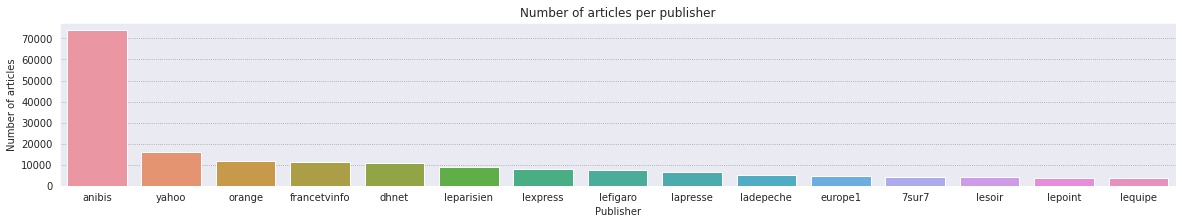

In [ ]:
#@title Number of articles publisher per publishers in the initial articles dataset
!gdown https://drive.google.com/uc?id=1FuW5JFhgA1DU2bFafssFb-dbKOOfRZhS
Image(filename="/content/distrib_publishers.png")

After that, we took a look at the most common (tokenized as it made more sense for statistics) words in the 16000 articles we kept. With no surprise, we find that stopwords occupy the top positions

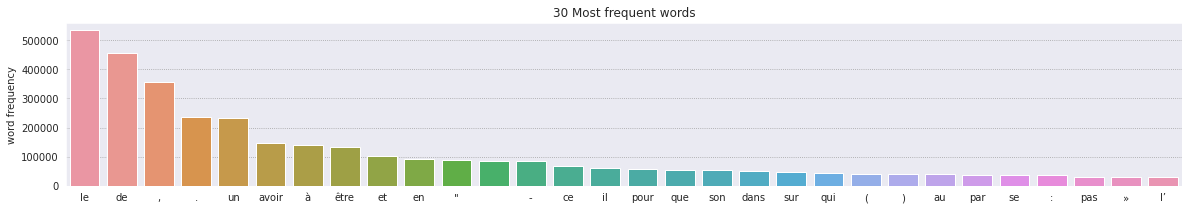

In [ ]:
#@title 30 most frequent words
!gdown https://drive.google.com/uc?id=1kKlYnMIuoGireo5-LUt34EPiVIuY8FqM
Image(filename="/content/most_common_news.png")

We also took a look at what were the top meaningful words (non articles non stopwords).

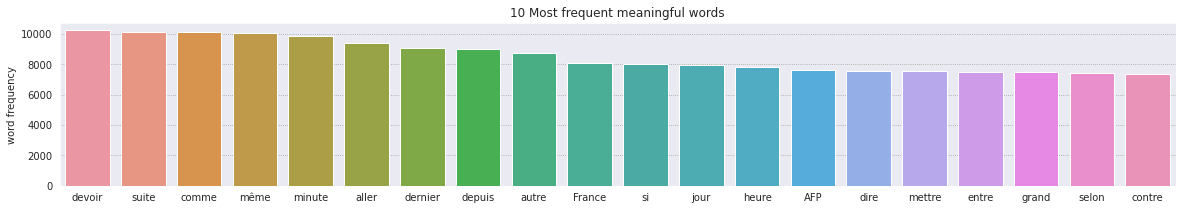

In [ ]:
#@title 20 most frequent meaningful words
!gdown https://drive.google.com/uc?id=1UULPthCkxG4QNwdNthXrL4VDpXa9TaUf
clear_output()
Image(filename="/content/most_common_news_clean.png")

We also visualized the zipf law in this dataset.

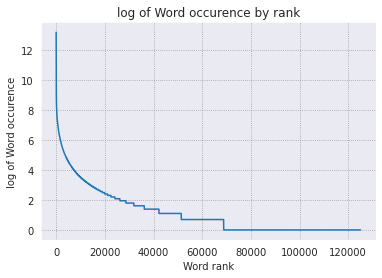

In [ ]:
#@title log of the number of word occurences per rank in the 16 000 articles
!gdown https://drive.google.com/uc?id=1G5P9FOHKoZWu-W9grMgnHqXDYQbgQMi3
clear_output()
Image(filename="/content/word_occurence.png")

We also took a look at the most common words in Proust's texts. Once again no surprise, we found stop words.

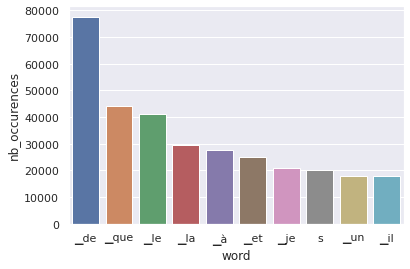

In [ ]:
#@title Most frequent words in Proust's texts
!gdown https://drive.google.com/uc?id=1MXx-xJJN8ljukaeEOLG6UJbKD9AfIKVu
clear_output()
Image(filename="/content/most_common_proust.png")

Finally, we took a look at the most frequent meaningful words in Proust's texts :

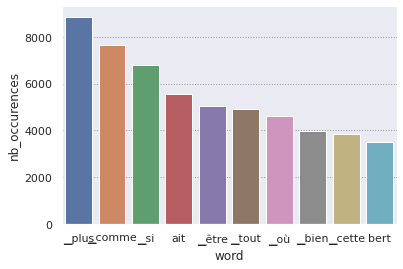

In [ ]:
#@title Most frequent words in Proust's texts
!gdown https://drive.google.com/uc?id=1bBQROOdFedd4yhFe1U9nEZCg3RbZI7EV
clear_output()
Image(filename="/content/most_common_proust_cleaned.png")

We download the dataset we worked with.

It contains both paragraphs from Proust's texts and the 16000 news articles.

In [ ]:
#@title download dataset
!gdown https://drive.google.com/uc?id=1q4cHZDGJ7SdWUPSl-eYdHCH62bKwuBW5

df = pd.read_csv('/content/dataset.csv', sep='|', index_col=0).dropna()

Downloading...
From: https://drive.google.com/uc?id=1q4cHZDGJ7SdWUPSl-eYdHCH62bKwuBW5
To: /content/dataset.csv
100% 47.2M/47.2M [00:00<00:00, 261MB/s]


The dummy model is very simple : we have a sentence in one given style. For each word of the sentence we try to find synonyms  of the words using nltk's implementation of wordnet for french. We refine this list by taking the synonyms with the right part-of-speech (POS) tag, using CamemBert POS tagger. Then, of these synonyms we take the one that is most common in the target style.

This has mixed results. On the bright side, a lot of the structural words of the sentence are left untouched because they are as common in both corpus. That keeps a lot of the meaning intact. However, it keeps the style change to a minimum

The other issue is that our synonym selection is too simple. The nltk wornet gives us synonyms purely based on the word and the POS. This does not take into account context. That means that the meaning, in context, of the word is often not preserved. In order to have better results with this technique, we could have found "synonyms" based on context aware embeddings. Finally, by the nature of this simplistic approach, we do not transfer style as much as we transfer vocabulary, which is a fundamentally limited approach.

In [ ]:
#@title dummy model

!gdown https://drive.google.com/uc?id=1MhLX360_Xv6QB9a95YUafjrxM_rbpNY0

!gdown https://drive.google.com/uc?id=1V3xk9hfv0YZ6Y5YyRXR5ENjdQ7Q24-Pw

tokenizer = AutoTokenizer.from_pretrained("gilf/french-camembert-postag-model")
model = AutoModelForTokenClassification.from_pretrained("gilf/french-camembert-postag-model")

nlp_token_class = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

def cleaning(text):
    text = re.sub("~@~Y", "'", text)
    text = re.sub( "(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)", "", text)
    text = re.sub("\/", "", text)
    text = re.sub("l'", "le ", text)
    text = re.sub("d'", "de ", text)
    text = re.sub("j'", "je ", text)
    text = re.sub("qu'", "que ", text)
    text = re.sub("t'", "te ", text)
    text = re.sub("c'", "ce ", text)
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub( ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return (text)

df['cleaned'] = df.text.apply(cleaning)
df['tokenized'] = df.cleaned.apply(tokenizer.tokenize)

df_proust = df[df.label == 1]
df_news = df[df.label == 0]

proust = pd.read_csv('proust.csv', index_col='word')
news = pd.read_csv('news.csv', index_col='word')

def get_corres_pos(camembert_pos):
    if camembert_pos == 'NC':
        return wn.NOUN
    if camembert_pos[0] == 'V':
        return wn.VERB
    if camembert_pos[:3] == 'ADJ':
        return wn.ADJ
    if camembert_pos[:3] == 'ADV':
        return wn.ADV
    return None


def dummy_transfer_sentences(df_sentences_idx):
  original_sentence=[]
  result=[]
  expected_labels=[]
  for idx in df_sentences_idx:
    sentence = df.iloc[idx].cleaned
    expected_labels.append(df.iloc[idx].label)
    if len(sentence)>514:
      sentence=sentence[:514]
    original_sentence.append(sentence)
    tagged = nlp_token_class(sentence)
    new_sentence = []
    for word in tagged:
        pos = get_corres_pos(word['entity_group'])
        if pos is None:
            new_sentence.append(word['word'])
        else:
            syns = [synset.lemma_names('fra') for synset in wordnet.synsets(word['word'], lang='fra', pos=pos)]
            if len(syns) == 0:
                new_sentence.append(word['word'])
            else:
                syns = list(set([word for syn in syns for word in syn]))
                syns = {''.join(tokenizer.tokenize(word)): word for word in syns}
                good_tokens = proust.index.intersection([syn for syn in syns.keys()])
                if len(good_tokens) == 0:
                    new_sentence.append(word['word'])
                else:
                    most_common_syn = proust.loc[good_tokens].iloc[0].name
                    new_sentence.append(syns[most_common_syn])
                    
    result.append(' '.join(new_sentence))
  return original_sentence,result,expected_labels

Downloading...
From: https://drive.google.com/uc?id=1MhLX360_Xv6QB9a95YUafjrxM_rbpNY0
To: /content/news.csv
100% 314k/314k [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V3xk9hfv0YZ6Y5YyRXR5ENjdQ7Q24-Pw
To: /content/proust.csv
100% 219k/219k [00:00<00:00, 75.3MB/s]


Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/token_classification.py:136: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  f'`grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="{aggregation_strategy}"` instead.'


In [ ]:
#@title example of use of dummy label
original_sentence,transfered_sentence,label =dummy_transfer_sentences([10])

print("Original sentence \n", original_sentence[0])
var = "news articles" if label[0]==0 else "Proust text"
print("Was taken from", var)
print("#############")
print("Sentence returned by dummy model \n",transfered_sentence[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Original sentence 
 près de un an après des victimes du novembre retournent au bataclan afp publié le lundi octobre à h novembre le association de victimes des attentats life for paris commémorera avec sobriété le anniversaire de la nuit tragique un rassemblement une table ronde fermée au public un concert de le orchestre des gardiens de la paix le association de victimes des attentats du novembre life for paris commémorera avec sobriété le anniversaire de la nuit tragique où personnes ont trouvé la mort un rassemblement public 
Was taken from news articles
#############
Sentence returned by dummy model 
 près de un à après des victimes du novembre retournent au batac lan afp publié le lundi octobre à h novembre le relation de victimes des attentats life for paris commémorera avec sobriété le fête de la soir tragique un réunion une table ronde fermée au monde un concert de le orchestre des gardiens de la chambre le relation de victimes des attentats du novembre life for paris commémore

The style model was trained using a classical gradient descent technique, with Cross Entropy for loss. For the optimizer we chose to use Adam. 

The cross entropy loss was used as what the model predicts is in fact a vector of the size of the vocabulary, vector from which we recover the most probable index.

In [ ]:
#@title load style transfer model from weights, model is named style_model

#define parameters dictionary
parameters_dict = {}

batch_size=64
style_embed_dim = 128 # dim of the Latent representation of the style variable
max_generated_sequence_len = 15
vocab_size = len(ft_vocab)-3 # since pretrained vectors do not have embedding for <s> <pad> and <unk> which are in vocabulary
hidden_dim=258
embed_size = 300
lr = 0.01

style_dict={"batch_size" :batch_size,"label_smoothing_sigma" : 0.1, "lr": lr, "style_embed_dim" : style_embed_dim, "max_generated_sequence_len":max_generated_sequence_len, "eos_idx":0, "vocab_size":vocab_size, "embed_size":embed_size, "sos_idx":index_sos}

encoder_dict={"nb_layers":1, "embed_size":embed_size,"hidden_dim":hidden_dim}
decoder_dict={"nb_layers":1, "embed_size":embed_size,"hidden_dim":hidden_dim}

autoencoder_dict={"encoder":encoder_dict,"decoder":decoder_dict}

parameters_dict["style"]=style_dict
parameters_dict["autoencoder"]=autoencoder_dict

#get model weights
!gdown https://drive.google.com/uc?id=1rk49gjzrvCP5BLGldFqAFO2W3ZFxx5KI


style_model = style_transfer(parameters_dict,pretrained_vectors)
style_model.load_state_dict(torch.load("/content/style_model"))

Downloading...
From: https://drive.google.com/uc?id=1rk49gjzrvCP5BLGldFqAFO2W3ZFxx5KI
To: /content/style_model
100% 68.8M/68.8M [00:00<00:00, 196MB/s]


<All keys matched successfully>

The model was trained to style transfer sentences of size 10, to style transfer a whole sentence we therefore split this sentence into tokens, and we transfer 10 tokens by 10 tokens

In [ ]:
#@title useful functions to style transfer whole sentences (only for batch of 64 sentences)
def retrieve_sentence(indexes,itos, idx_end):
  '''returns sentences from tokens
  indexes : 2 dim tensor (batch size, nb tokens)'''
  sentences = []
  extended_itox = itos + ["<pad>","<unk>","<s>"]
  for list_indexes in indexes:
    sentence=[]
    for index in list_indexes :

      if index == idx_end:
        
        break
      
      else:

        sentence.append(extended_itox[index])
    sentence = " ".join(sentence)
    sentences.append(sentence)
  return sentences

def get_sentences_tokenized_to_good_size(sentences, tokenizer_function, nb_tokens, pad_token="<pad>"):
  '''transform text sentences into list of tokens of same len
  sentences : list of str sentences'''
    
  splits = []
  len_tokenized_sentences=[]

  for sentence in sentences :
    tokens = tokenizer_function(sentence)
      
    if len(tokens) < nb_tokens:

      tokens = tokens + [pad_token for i in range(nb_tokens-len(tokens))]
      
    else:
      tokens = tokens [:nb_tokens]

    splits.append(tokens)
    
  return splits

def split_into_batches_of_idx( split, nb_tokens, batch_size, vocab, start_token="<s>", end_token="</s>", sequence_size=10):
  '''split result of get_sentences_tokenized_to_good_size into batches'''

  nb_batches = nb_tokens // sequence_size
  batches = []
    
  for i in range(nb_batches) :
      
    result =  []

    for k in range(batch_size) :

      token_sentence = split[k]
      sequence = token_sentence[i*sequence_size : (i+1)*sequence_size ]
      result.append([vocab[start_token]] + [vocab[word] for word in sequence] + [vocab[end_token]])
      
    batches.append(result)
    
  return batches

def get_list_of_batches_from_sentences(sentences, tokenizer_function, nb_tokens, vocab, batch_size=64, sequence_size=10):
  '''takes a list of sentences as argument and returns list of batches if size index'''
  split = get_sentences_tokenized_to_good_size(sentences, tokenizer_function, nb_tokens)
  res = split_into_batches_of_idx( split, nb_tokens, batch_size, vocab)
  return(res)

def style_transfer_sentences(sentences, tokenizer_function, nb_tokens, vocab, model, labels, itos, idx_end = 0):
  
  labels = torch.tensor(labels).view(-1,1,1)
  batches = get_list_of_batches_from_sentences(sentences, tokenizer_function, nb_tokens, vocab)
  res_sentences = ["" for i in range(64)]
  for batch in batches:
    predictions = model.predict(torch.tensor(batch), labels, 1-labels)
    text_sentences = retrieve_sentence(predictions, itos, idx_end)

    for i in range(64):
      res_sentences[i] += text_sentences[i]
  return res_sentences

Below we retrieve a list of 64 sentences and their labels

In [ ]:
#@title retrieve sentences and labels from dataset

np.random.seed(10)
list_text=np.random.choice(range(len(df)), size = 64, replace = False)

texts=[]
labels=[]

for i in range(64) :
  texts.append(df.iloc[list_text[i]]["text"])
  labels.append(df.iloc[list_text[i]]["label"])

pprint.pprint(texts[0])
print(labels[0])


("— J'avoue à ma honte que je n'en suis pas choquée, dit la princesse des "
 'Laumes.')
1


We use our style transfer model on the previously sampled sentences and labels.

In [ ]:
#@title style transfer the previously retrieved sentences to opposite style.
results = style_transfer_sentences(texts, tokenizer_function, 50, ft_vocab, style_model, [1 - labels[i] for i in range(64)], itos )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
#@title Print a sampled sentence and the style transfered generated sentence. Rerun cell after choosing another sentence_nb
sentence_nb = "14" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
sentence_nb = int(sentence_nb)
type_sentence = "articles" if labels[sentence_nb-1] == 0 else "Proust"
print("Original sentence of style", type_sentence,":")
print("########################################")
text = texts[sentence_nb-1]
tokens = " ".join(tokenizer_function(text)[:50])
pprint.pprint(tokens)
print("########################################")
print("transfered sentence :")
print("########################################")
pprint.pprint(results[sentence_nb-1])


Original sentence of style Proust :
########################################
("m . de charlus m' eût sans doute pardonné mon manque de reconnaissance . "
 'mais ce qui le rendait furieux , ce est que ma présence ce soir chez la '
 'princesse de guermantes , comme depuis quelque temps chez sa cousine , '
 'paraissait narguer la déclaration solennelle : " on')
########################################
transfered sentence :
########################################
('<s> prédécesseur schumacher existence blackrock emphase psychiatrie janus '
 'socle kong psychanalyste fatiguée oeuf opposer montpelliérains ironisé<s> '
 'écrivait entrainement émotions amenés inquiétants su shanghai catholicisme '
 'confie impatients classic cessais rayonner dupras enquêtant<s> réalisateur '
 'apporter abuser bonnes sodome bris collèges avidement attaquées pen pins '
 'budget exerçait séparé genève<s> collectif tom obligatoire réclamait disons '
 'abri constatés endosser dominant maximal désirs budgétaire bal

We also decided to build a classifier which aimed to distinguish between the two styles : news articles (label 0) and Proust (label 1).

We did that for 2 reasons : 

First, we wanted to make sure that the two type of texts (articles and Proust's texts) where different enough, as style transfer only works on datasets which styles are different. We achieved an accuracy score of 93 % on validation dataset for this classifier, which seemed to validate that the two styles were different.

The second reason was for an evaluation reason, we needed a way to evaluate our models, but it seems like there are no classical measure metrics for non parallel seq2seq. 

The idea is that when applying the style transfer models (either the dummy or the rnn based one) to a sentence of a given style, let's say article news, we expect the ouput to have the opposite style, in our example Proust style.

We then decided to use our classifier on each output sentence to predict the style of this text, and we compare this style to the expected style. If the classifier predicted that the style of the output was the same as the style of the input, we labeled this prediction as a mistake otherwise we

For instance, if we use a model on a news article sentence to obtain an output transfered sentence, if the style of the output transfered sentence predicted by the classifier is the same as the style of the input sentence we consider that our transfer model did not transfer the initial sentence. 

In [ ]:
#@title classifier classes

from transformers import CamembertModel, CamembertTokenizer
import torch
import numpy as np
import torch.nn as nn
import random
import time
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from pathlib import Path
import pandas as pd
from pathlib import Path
import os
import re
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import string
from sklearn.metrics import matthews_corrcoef

class CamemBertClassifier(nn.Module):

    def __init__(self, weights=None):
        super(CamemBertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

        self.tokenizer = CamembertTokenizer.from_pretrained("camembert-base",
                                                            do_lower_case=True)
        self.bert = CamembertModel.from_pretrained("camembert-base")
        self.classifier = nn.Sequential(nn.Linear(D_in, H), nn.ReLU(),
                                        nn.Linear(H, D_out))
        if weights is not None:
            self.load_state_dict(weights)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits
class StyleDataset:

    def __init__(self,
                 tokenizer,
                 split_ratios=(0.80, 0.10),
                 batch_size=32,
                 max_len=175):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.split_ratios = split_ratios
        self.data_dir = Path('/content/')
        self.path = self.data_dir / Path('dataset.csv')
        self.df = pd.read_csv(self.path, sep='|', index_col=0)
        self.format()
        self.dataset = self.tokenize()
        self.split = self.get_ratios()
        self.train_df, self.val_df, self.test_df = random_split(
            self.dataset, self.split)
        self.train_dataloader, self.val_dataloader, self.test_dataloader = self.get_dataloaders(
        )

    def format(self):
        print("Formatting data ...")
        self.df = self.df[['label', 'text']]
        self.df.text = self.df.text.apply(str)
        self.df = self.df.rename(columns={'label': 'y', 'text': 'X'})
        self.df.X = self.df.X.apply(self.preprocessing)
        # self.df = self.df.sample(1500)

    def preprocessing(self, text):
        text = re.sub("’", "'", text)
        #Remove unwanted characters
        text = re.sub(
            "(@\w*\\b\s?|#\w*\\b\s?|&\w*\\b\s?|\n\s?|\\\\|\<|\>|\||\*)", "",
            text)
        text = re.sub("\/", "", text)
        #Replace articles since model does not embed contractions well
        text = re.sub("l'", "le ", text)
        text = re.sub("d'", "de ", text)
        text = re.sub("j'", "je ", text)
        text = re.sub("qu'", "que ", text)
        text = re.sub("t'", "te ", text)
        text = re.sub("c'", "ce ", text)
        text = text.lower()
        text = text.strip()
        text = re.compile('<.*?>').sub('', text)
        text = re.compile('[%s]' % re.escape(string.punctuation)).sub(
            ' ', text)
        text = re.sub('\s+', ' ', text)
        text = re.sub(r'\[[0-9]*\]', ' ', text)
        text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
        text = re.sub(r'\d', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return (text)

    def get_ratios(self):
        train_ratio, val_ratio = self.split_ratios
        len_df = len(self.dataset)
        train_size = int(len_df * train_ratio)
        val_size = int(len_df * val_ratio)
        test_size = len_df - train_size - val_size
        return train_size, val_size, test_size

    def get_dataloaders(self):
        train_dataloader = DataLoader(self.train_df,
                                      sampler=RandomSampler(self.train_df),
                                      batch_size=self.batch_size)
        validation_dataloader = DataLoader(self.val_df,
                                           sampler=SequentialSampler(
                                               self.val_df),
                                           batch_size=self.batch_size)
        test_dataloader = DataLoader(self.test_df,
                                     sampler=SequentialSampler(self.test_df),
                                     batch_size=self.batch_size)
        return train_dataloader, validation_dataloader, test_dataloader

    def __len__(self):
        return len(self.df)

    def tokenize(self):
        input_ids = []
        attention_masks = []

        for sentence in self.df.X.values:
            encoded_sent = self.tokenizer.encode_plus(
                text=sentence,  
                add_special_tokens=True,  
                max_length=self.max_len, 
                truncation=True,
                padding='max_length',
                return_attention_mask=True  
            )
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        dataset = TensorDataset(input_ids, attention_masks,
                                torch.tensor(self.df.y.values))
        return dataset

    def get_max_len(self, tokenizer):
        max_len = 0
        for sentence in self.data.X:
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            max_len = max(max_len, len(input_ids))
        return (max_len)
class EarlyStopper():

    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(
                f"INFO: Early stopping counter {self.counter} of {self.patience}"
            )
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
class Trainer:

    def __init__(self, model, dataset, lr=5e-5, eps=1e-8, device=torch.device("cpu"), epochs=4):
        self.set_seed()
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.dataset = dataset
        self.epochs = epochs
        self.early_stopper = EarlyStopper()
        self.optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
        self.steps = len(dataset) * epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=self.steps)
        self.train_dataloader = self.dataset.train_dataloader
        self.val_dataloader = self.dataset.val_dataloader
        self.test_dataloader = self.dataset.test_dataloader

    def set_seed(self, seed_value=42):
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

    def train(self, evaluation=False):
        print("Start training...\n")
        for epoch_i in range(self.epochs):
            print(
                f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}"
            )
            print("-" * 70)
            t0_epoch, t0_batch = time.time(), time.time()
            total_loss, batch_loss, batch_counts = 0, 0, 0
            self.model.train()
            for step, batch in enumerate(self.train_dataloader):
                batch_counts += 1
                b_input_ids, b_attn_mask, b_labels = tuple(
                    t.to(self.device) for t in batch)
                self.model.zero_grad()
                logits = self.model(b_input_ids, b_attn_mask)
                loss = self.loss_fn(logits, b_labels)
                batch_loss += loss.item()
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                if (step % 20 == 0
                        and step != 0) or (step
                                           == len(self.train_dataloader) - 1):
                    time_elapsed = time.time() - t0_batch
                    val_loss, val_accuracy = self.evaluate()
                    print(
                        f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}"
                    )
                    self.early_stopper(val_loss)
                    if self.early_stopper.early_stop:
                        print("Training complete!")
                        return (0)
                    batch_loss, batch_counts = 0, 0
                    t0_batch = time.time()

            avg_train_loss = total_loss / len(self.train_dataloader)

            print("-" * 70)
            if evaluation == True:
                val_loss, val_accuracy = self.evaluate()
                time_elapsed = time.time() - t0_epoch
                print(
                    f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}"
                )
                print("-" * 70)
            print("\n")

        print("Training complete!")

    def evaluate(self):
        self.model.eval()

        val_accuracy = []
        val_loss = []

        for batch in self.val_dataloader:
            input_ids, attn_mask, labels = tuple(
                t.to(self.device) for t in batch)
            with torch.no_grad():
                logits = self.model(input_ids, attn_mask)
            loss = self.loss_fn(logits, labels)
            val_loss.append(loss.item())
            preds = torch.argmax(logits, dim=1).flatten()
            accuracy = (preds == labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

    def predict(self):
        self.model.eval()

        predictions, true_labels = [], []

        for batch in self.test_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=input_mask)
            logits = outputs
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            predictions.append(logits)
            true_labels.append(label_ids)
        return predictions, true_labels

    def save(self, path=None):
        model_path = Path('models_trained')
        if not model_path.is_dir():
            os.mkdir(model_path)
        if path is None:
            path = model_path/"camembert"
        torch.save(self.model.state_dict(), path)



The classifier was trained using a classical gradient descent technique, with Cross Entropy for loss. Cross entropy is the most usual loss for classification tasks, so no innovation here. For optimizer we chose to use AdamW, which is a variant of the classical optimizer Adam, with added weight decay. It is a form of regularization, meaning that it reduces the chances of overfitting. 

We retrieve the weights below.

In [ ]:
#@title load classifier 

!gdown https://drive.google.com/uc?id=1MjBWPSiIy2UnGZLCKXwDFjx4kTF_1_H3
clear_output()
cam_classifier = CamemBertClassifier()
cam_classifier.load_state_dict(torch.load('/content/camembert_sentences'))
dataset = StyleDataset(cam_classifier.tokenizer)


def get_pred(model, dataset, sentence):
    model.eval()
    encoded = model.tokenizer.encode_plus(
        text=sentence,  
        add_special_tokens=True,  
        max_length=dataset.max_len, 
        truncation=True,
        padding='max_length',
        return_attention_mask=True  
    )
    input_ids, input_mask = encoded['input_ids'], encoded['attention_mask']
    with torch.no_grad():
        output = model(torch.tensor(input_ids).unsqueeze(dim=0), attention_mask=torch.tensor(input_mask).unsqueeze(dim=0))
    softmax = nn.Softmax(dim=1)
    return (softmax(output))

def get_preds(model, dataset, sentences):
  result_sentences=[]
  for sentence in sentences:
    result_sentence = get_pred(model, dataset, sentence)
    result_sentences.append((torch.argmax(result_sentence)).item())
  return result_sentences

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Formatting data ...


Test the classifier on a sentence :

In [ ]:
example_sentence = df.iloc[14].text
example_label = df.iloc[14].label
classifier_prediction = get_pred(cam_classifier,dataset,example_sentence)
predicted_label = (torch.argmax(classifier_prediction)).item()

print("For the sentence : \n",example_sentence[:50]," ... (truncated sentence)")
print("\n With real label",example_label,"(coming from news article) the classifier predicted",predicted_label)

For the sentence : 
 Société Plus de 260 viols ou tentatives par jour e  ... (truncated sentence)

 With real label 0 (coming from news article) the classifier predicted 0


below we test our models.

## dummy model test

We test our dummy model on 100 sampled sentences, but we find out that on the picked 100 sentences the dummy model has an accuracy of 0 target output style vs style predicted by classifier

In [ ]:
size = 100
idx_sample = np.random.choice(range(len(df)), size = size, replace=False)
_,dummy_generated_sentences,labels = dummy_transfer_sentences(idx_sample)

classifier_dummy = get_preds(cam_classifier,dataset,dummy_generated_sentences)

nb_wrong_labels = (np.absolute((1-np.array(labels))-classifier_dummy)).sum()

accuracy = (size-nb_wrong_labels)/size

print("on batch of size",size," we have an accuracy of",accuracy)

on batch of size 100  we have an accuracy of 0.0


## style transfer model test

We use the sentences transfered by our rnn style model above to compute a metric. We limited ourselves to a test on 64 sentences. 

We realized that the sentences do not make any sense, which may result from the fact that we use a single unidirectionnal gru cell as rnn, therefore facing the fading gradient issue.

In [ ]:
#@title classify transfered sentences
classifier_predictions = get_preds(cam_classifier,dataset,results)

In [ ]:
size = 64
output_labels =1-np.array(labels)
res = (np.absolute(np.array(classifier_predictions)-output_labels)).sum()


print("Our style transfer model achieved an accuracy of",((size-res)/size))

Our style transfer model achieved an accuracy of 0.34375


We achieved an accuracy of 35 % using our transfer model. This is really low, but even the more advanced model proposed in the article
  [Style Transfer from Non-Parallel Text by Cross-Alignment](https://arxiv.org/abs/1705.09655) on which we based our methodology ( They used adversarial training to train their style transfer model) only achieved slightly better results, though most likely while retaining the content of the text.